In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets
 
import torchvision
from torchvision import transforms
from torchvision import models
 
import torch.nn.functional as F
import torchvision.transforms.functional as TF
 
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time

from tqdm import tqdm # progress bar

import skimage
import cv2

from glob import glob

from torchsummary import summary

import math
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cpu


In [2]:
#########################################
# Parameters 
#########################################

viz_image_paths = glob('/Users/racoon/Documents/sc_patch/src/evaluation_metric/dataset_100/train/*/*.jpg')
training_image_paths = glob('/Users/racoon/Documents/sc_patch/src/evaluation_metric/dataset_100/train/*/*.jpg')
validation_image_paths = glob('/Users/racoon/Documents/sc_patch/src/evaluation_metric/dataset_100/train/*/*.jpg')

train_dataset_length = 40960
validation_dataset_length = 4096
train_batch_size = 128
validation_batch_size = 128
num_epochs = 3000
save_after_epochs = 1 
backup_after_epochs = 10 
model_save_prefix = "rotation_jigsaw"
color_shift = 1
patch_dim = 96
jitter = 16
gray_portion = .30
reuse_image_count = 4

learn_rate = 0.001
momentum = 0.974
weight_decay = 0.0005



In [3]:
#########################################
# Utilities 
#########################################

def imshow(img,text=None,should_save=False):
    plt.figure(figsize=(10, 10))
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  

def show_plot(iteration,loss,fname):
    plt.plot(iteration,loss)
    plt.savefig(fname)
    plt.show()
    
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for i, t in enumerate(tensor):
            t.mul_(self.std[i%3]).add_(self.mean[i%3])
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))




In [126]:

#########################################
# This class generates patches for training
#########################################

patch_order_arr = [
  (0, 1, 2, 3),
  (0, 1, 3, 2),
  (0, 2, 1, 3),
  (0, 2, 3, 1),
  (0, 3, 1, 2),
  (0, 3, 2, 1),
  (1, 0, 2, 3),
  (1, 0, 3, 2),
  (1, 2, 0, 3),
  (1, 2, 3, 0),
  (1, 3, 0, 2),
  (1, 3, 2, 0),
  (2, 0, 1, 3),
  (2, 0, 3, 1),
  (2, 1, 0, 3),
  (2, 1, 3, 0),
  (2, 3, 0, 1),
  (2, 3, 1, 0),
  (3, 0, 1, 2),
  (3, 0, 2, 1),
  (3, 1, 0, 2),
  (3, 1, 2, 0),
  (3, 2, 0, 1),
  (3, 2, 1, 0)
]

class ShufflePatchDataset(Dataset):

  def __init__(self, image_paths, patch_dim, length, jitter, color_shift, transform=None):
    self.image_paths = image_paths
    self.patch_dim = patch_dim
    self.length = length
    self.jitter = jitter
    self.color_shift = color_shift
    self.transform = transform
    self.image_reused = 0

    self.sub_window_width = self.patch_dim + 2*self.jitter + 2*self.color_shift
    self.window_width = 2*self.sub_window_width
    
    self.min_image_width = self.window_width + 1

    self.saliency = cv2.saliency.StaticSaliencyFineGrained_create()

  def __len__(self):
    return self.length

  def random_jitter(self):
    return int(math.floor((self.jitter * 2 * random.random())))

  def random_shift(self):
    return random.randrange(self.color_shift * 2 + 1)

  def prep_patch(self, image):
 
    cropped = np.empty((self.patch_dim, self.patch_dim, 3), dtype=np.uint8)

    if(random.random() < gray_portion):

      pil_patch = Image.fromarray(image)
      pil_patch = pil_patch.convert('L')
      pil_patch = pil_patch.convert('RGB')
      np.copyto(cropped, np.array(pil_patch)[self.color_shift:self.color_shift+self.patch_dim, self.color_shift:self.color_shift+self.patch_dim, :])
      
    else:

      shift = [self.random_shift() for _ in range(6)]
      cropped[:,:,0] = image[shift[0]:shift[0]+self.patch_dim, shift[1]:shift[1]+self.patch_dim, 0]
      cropped[:,:,1] = image[shift[2]:shift[2]+self.patch_dim, shift[3]:shift[3]+self.patch_dim, 1]
      cropped[:,:,2] = image[shift[4]:shift[4]+self.patch_dim, shift[5]:shift[5]+self.patch_dim, 2]

    return cropped

  def saliency_check(self, window, patch_coords):
    (success, saliency_map) = self.saliency.computeSaliency(cv2.cvtColor(window, cv2.COLOR_RGB2BGR))

    high_saliency_patches = 0
    med_saliency_patches = 0
    
    for p in patch_coords:
        patch_saliency_map = saliency_map[p[0]:p[0]+self.patch_dim, p[1]:p[1]+self.patch_dim]
        patch_saliency = np.sum(patch_saliency_map > .40)
        print(patch_saliency)
        if patch_saliency >= 400:
          high_saliency_patches += 1
        elif patch_saliency >= 150:
          med_saliency_patches += 1

    print((high_saliency_patches > 0 and (high_saliency_patches + med_saliency_patches) > 2))
    return True
    
    # return (high_saliency_patches > 0 and (high_saliency_patches + med_saliency_patches) > 2)



  def __getitem__(self, index):
    # [y, x, chan], dtype=uint8, top_left is (0,0)
    
    image_index = int(math.floor((len(self.image_paths) * random.random())))
    
    if self.image_reused == 0:
      self.pil_image = Image.open(self.image_paths[image_index]).convert('RGB')
      self.image_reused = reuse_image_count - 1
    else:
      self.image_reused -= 1

    image = np.array(self.pil_image)

    # If image is too small, try another image
    if (image.shape[0] - self.min_image_width) <= 0 or (image.shape[1] - self.min_image_width) <= 0:
        return self.__getitem__(index)
    
    window_y_coord = int(math.floor((image.shape[0] - self.window_width) * random.random()))
    window_x_coord = int(math.floor((image.shape[1] - self.window_width) * random.random()))

    window = image[window_y_coord:window_y_coord+self.window_width, window_x_coord:window_x_coord+self.window_width]
    
    rotation_label = int(math.floor((4 * random.random())))
    order_label = int(math.floor((24 * random.random()))) 
    
    if rotation_label>0:
      window = np.rot90(window, rotation_label).copy()

    patch_coords = [
      (self.random_jitter(), self.random_jitter()),
      (self.random_jitter(), self.sub_window_width + self.random_jitter()),
      (self.sub_window_width + self.random_jitter(), self.random_jitter()),
      (self.sub_window_width + self.random_jitter(), self.sub_window_width + self.random_jitter()),
    ]

    patch_coords = [pc for _,pc in sorted(zip(patch_order_arr[order_label],patch_coords))]

    if not self.saliency_check(window, patch_coords):
      return self.__getitem__(index)

    patch_a = window[patch_coords[0][0]:patch_coords[0][0]+self.patch_dim+2*self.color_shift, patch_coords[0][1]:patch_coords[0][1]+self.patch_dim+2*self.color_shift]
    patch_b = window[patch_coords[1][0]:patch_coords[1][0]+self.patch_dim+2*self.color_shift, patch_coords[1][1]:patch_coords[1][1]+self.patch_dim+2*self.color_shift]
    patch_c = window[patch_coords[2][0]:patch_coords[2][0]+self.patch_dim+2*self.color_shift, patch_coords[2][1]:patch_coords[2][1]+self.patch_dim+2*self.color_shift]
    patch_d = window[patch_coords[3][0]:patch_coords[3][0]+self.patch_dim+2*self.color_shift, patch_coords[3][1]:patch_coords[3][1]+self.patch_dim+2*self.color_shift]

    # gray = random.random() < gray_portion

    patch_a = self.prep_patch(patch_a)
    patch_b = self.prep_patch(patch_b)
    patch_c = self.prep_patch(patch_c)
    patch_d = self.prep_patch(patch_d)

    combined_label = np.array(rotation_label * 24 + order_label).astype(np.int64)
        
    if self.transform:
      patch_a = self.transform(patch_a)
      patch_b = self.transform(patch_b)
      patch_c = self.transform(patch_c)
      patch_d = self.transform(patch_d)

    return patch_a, patch_b, patch_c, patch_d, combined_label
    

In [127]:

##################################################
# Creating Train/Validation dataset and dataloader
##################################################


vizdataset = ShufflePatchDataset(viz_image_paths, patch_dim, 1, jitter, color_shift,
                         transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

vizloader = torch.utils.data.DataLoader(vizdataset,
                                        batch_size=1,
                                        shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5197
3587
294
1043
True


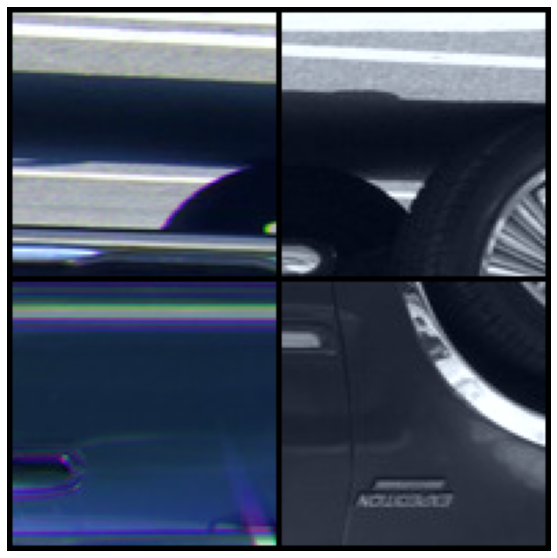

Labels: [48]


In [193]:
#############################
# Visualizing validation dataset
#############################

example_batch_val = next(iter(vizloader))
concatenated = torch.cat((unorm(example_batch_val[0]),unorm(example_batch_val[1]),unorm(example_batch_val[2]),unorm(example_batch_val[3])),0)
imshow(torchvision.utils.make_grid(concatenated, nrow=2))
print(f'Labels: {example_batch_val[4].numpy()}')


In [22]:
##################################################
# Model for learning patch position
##################################################

class VggNetwork(nn.Module):
  def __init__(self,aux_logits = False):

      super(VggNetwork, self).__init__()

      self.cnn = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64), 
        nn.ReLU(inplace=True),

        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64), 
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128), 
        nn.ReLU(inplace=True),

        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128), 
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256), 
        nn.ReLU(inplace=True),

        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256), 
        nn.ReLU(inplace=True),

        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256), 
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512), 
        nn.ReLU(inplace=True),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512), 
        nn.ReLU(inplace=True),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512), 
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512), 
        nn.ReLU(inplace=True),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512), 
        nn.ReLU(inplace=True),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512), 
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2)
      )
    
      self.fc6 = nn.Sequential(
        nn.Linear(512 * 3 * 3, 4096),
        nn.ReLU(True),
        nn.Dropout(),
      )

      self.fc = nn.Sequential(
        nn.Linear(4*4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 96),
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output

  def forward(self, patch_a, patch_b, patch_c, patch_d):
    output_fc6_patch_a = self.forward_once(patch_a)
    output_fc6_patch_b = self.forward_once(patch_b)
    output_fc6_patch_c = self.forward_once(patch_c)
    output_fc6_patch_d = self.forward_once(patch_d)

    output = torch.cat((output_fc6_patch_a, output_fc6_patch_b, output_fc6_patch_c, output_fc6_patch_d), 1)
    output = self.fc(output)

    return output, output_fc6_patch_a, output_fc6_patch_b, output_fc6_patch_c, output_fc6_patch_d

model = VggNetwork().to(device)
summary(model, [(3, patch_dim, patch_dim), (3, patch_dim, patch_dim), (3, patch_dim, patch_dim), (3, patch_dim, patch_dim)])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
       BatchNorm2d-2           [-1, 64, 96, 96]             128
              ReLU-3           [-1, 64, 96, 96]               0
            Conv2d-4           [-1, 64, 96, 96]          36,928
       BatchNorm2d-5           [-1, 64, 96, 96]             128
              ReLU-6           [-1, 64, 96, 96]               0
         MaxPool2d-7           [-1, 64, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]          73,856
       BatchNorm2d-9          [-1, 128, 48, 48]             256
             ReLU-10          [-1, 128, 48, 48]               0
           Conv2d-11          [-1, 128, 48, 48]         147,584
      BatchNorm2d-12          [-1, 128, 48, 48]             256
             ReLU-13          [-1, 128, 48, 48]               0
        MaxPool2d-14          [-1, 128,